In [2]:
#################################################
# STEP 1: Load Dataset and Standardize Column Names
# This step loads the water quality CSV and prepares column names
#################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
file_path = 'dataset.csv'
try:
    df_original = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip', low_memory=False)
    print(f"Successfully loaded {file_path}. Shape: {df_original.shape}")
except Exception as e:
    print(f"Error loading CSV: {e}")
    df_original = None

# --- Initial Cleaning & Column Name Standardization ---
if df_original is not None:
    df = df_original.copy() # Work on a copy
    
    # Standardize column names
    df.columns = df.columns.str.strip() 
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
    df.columns = df.columns.str.lower()
    print("\nStandardized Column Names (sample):", df.columns[:5].tolist(), "...")

    # Drop rows that are mostly empty early on
    initial_rows = df.shape[0]
    min_valid_values = 5 # Threshold for valid values in a row
    df.dropna(thresh=min_valid_values, inplace=True)
    print(f"\nDropped {initial_rows - df.shape[0]} rows with less than {min_valid_values} valid values.")
else:
    print("Skipping further steps as data loading failed.")

Successfully loaded dataset.csv. Shape: (2766, 20)

Standardized Column Names (sample): ['stn_code', 'name_of_monitoring_location', 'type_water_body', 'state_name', 'min_temperature'] ...

Dropped 11 rows with less than 5 valid values.


In [3]:
#################################################
# STEP 2: Select Target Variables and Convert to Numeric
# This step selects specific water quality parameters and converts them to numerical values
#################################################

if 'df' in locals() and df is not None:
    # --- Define Target Variable Columns (based on cleaned names) ---
    target_columns_minmax = [
        'min_dissolved_oxygen', 'max_dissolved_oxygen',
        'min_ph', 'max_ph',
        'min_conductivity', 'max_conductivity',
        'min_bod', 'max_bod',
        'min_nitrate_n__nitrite_n', 'max_nitrate_n__nitrite_n',
        'min_fecal_coliform', 'max_fecal_coliform',
        'min_total_coliform', 'max_total_coliform'
    ]

    # Define identifier column (will be dropped later)
    identifier_col = 'stn_code' 
    columns_to_keep = [identifier_col] + target_columns_minmax
    
    # Check which columns actually exist
    existing_cols = [col for col in columns_to_keep if col in df.columns]
    missing_req_cols = [col for col in target_columns_minmax if col not in df.columns]
    
    if missing_req_cols:
        print(f"\nWarning: The following required measurement columns were not found: {missing_req_cols}")
        
    print(f"\nSelecting subset of columns ({len(existing_cols)}): {existing_cols}")
    df_subset = df[existing_cols].copy()

    # --- Convert Target Columns to Numeric ---
    numeric_cols_in_subset = [col for col in target_columns_minmax if col in df_subset.columns]
    print("\nConverting selected columns to numeric...")
    for col in numeric_cols_in_subset:
        original_dtype = df_subset[col].dtype
        num_nan_before = df_subset[col].isnull().sum()
        df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')
        num_nan_after = df_subset[col].isnull().sum()
        if num_nan_after > num_nan_before:
             print(f"  - Converted '{col}'. Introduced {num_nan_after - num_nan_before} NaNs.")
        elif original_dtype != df_subset[col].dtype:
             print(f"  - Converted '{col}' to numeric.")
             
    print("\nNumeric conversion complete.")
    print("Shape of subset DataFrame:", df_subset.shape)
    df_subset.info()
else:
    print("Skipping step - Initial DataFrame 'df' not available.")


Selecting subset of columns (15): ['stn_code', 'min_dissolved_oxygen', 'max_dissolved_oxygen', 'min_ph', 'max_ph', 'min_conductivity', 'max_conductivity', 'min_bod', 'max_bod', 'min_nitrate_n__nitrite_n', 'max_nitrate_n__nitrite_n', 'min_fecal_coliform', 'max_fecal_coliform', 'min_total_coliform', 'max_total_coliform']

Converting selected columns to numeric...
  - Converted 'min_dissolved_oxygen'. Introduced 48 NaNs.
  - Converted 'max_dissolved_oxygen'. Introduced 40 NaNs.
  - Converted 'min_ph'. Introduced 28 NaNs.
  - Converted 'max_ph'. Introduced 28 NaNs.
  - Converted 'min_conductivity'. Introduced 43 NaNs.
  - Converted 'max_conductivity'. Introduced 43 NaNs.
  - Converted 'min_bod'. Introduced 47 NaNs.
  - Converted 'max_bod'. Introduced 36 NaNs.
  - Converted 'min_nitrate_n__nitrite_n'. Introduced 192 NaNs.
  - Converted 'max_nitrate_n__nitrite_n'. Introduced 182 NaNs.
  - Converted 'min_fecal_coliform'. Introduced 161 NaNs.
  - Converted 'max_fecal_coliform'. Introduced 153

In [4]:
#################################################
# STEP 3: Handle Missing Values in Selected Columns
# This step imputes missing values using the median for each column
#################################################

if 'df_subset' in locals() and not df_subset.empty:
    # --- Impute Missing Values in the Subset ---
    missing_before = df_subset.isnull().sum().sum()
    print(f"\nTotal missing values in subset before imputation: {missing_before}")
    
    # Use median for imputation as water quality data is often skewed
    numeric_cols_to_impute = [col for col in target_columns_minmax if col in df_subset.columns]
    
    print("Imputing missing values using median...")
    for col in numeric_cols_to_impute:
        if df_subset[col].isnull().any():
            median_val = df_subset[col].median()
            df_subset[col].fillna(median_val, inplace=True)
            print(f"  - Imputed NaNs in '{col}' with median: {median_val:.2f}")
            
    missing_after = df_subset.isnull().sum().sum()
    print(f"Total missing values in subset after imputation: {missing_after}")
else:
     print("Skipping step - DataFrame 'df_subset' not available.")


Total missing values in subset before imputation: 1995
Imputing missing values using median...
  - Imputed NaNs in 'min_dissolved_oxygen' with median: 4.40
  - Imputed NaNs in 'max_dissolved_oxygen' with median: 7.00
  - Imputed NaNs in 'min_ph' with median: 7.00
  - Imputed NaNs in 'max_ph' with median: 8.00
  - Imputed NaNs in 'min_conductivity' with median: 339.00
  - Imputed NaNs in 'max_conductivity' with median: 790.00
  - Imputed NaNs in 'min_bod' with median: 2.20
  - Imputed NaNs in 'max_bod' with median: 5.40
  - Imputed NaNs in 'min_nitrate_n__nitrite_n' with median: 0.52
  - Imputed NaNs in 'max_nitrate_n__nitrite_n' with median: 2.61
  - Imputed NaNs in 'min_fecal_coliform' with median: 45.00
  - Imputed NaNs in 'max_fecal_coliform' with median: 353.00
  - Imputed NaNs in 'min_total_coliform' with median: 350.00
  - Imputed NaNs in 'max_total_coliform' with median: 1500.00
Total missing values in subset after imputation: 29


/var/folders/0l/mrtqnjts01v_48lkl9674g3r0000gn/T/ipykernel_25961/3727376077.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_subset[col].fillna(median_val, inplace=True)
/var/folders/0l/mrtqnjts01v_48lkl9674g3r0000gn/T/ipykernel_25961/3727376077.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw


Applying IQR capping for outlier handling...
  - Capped 0 low / 3 high outliers in 'min_dissolved_oxygen'. Bounds: [-3.70, 11.50]
  - Capped 184 low / 99 high outliers in 'max_dissolved_oxygen'. Bounds: [2.90, 10.90]
  - Capped 43 low / 45 high outliers in 'min_ph'. Bounds: [5.80, 8.20]
  - Capped 3 low / 36 high outliers in 'max_ph'. Bounds: [6.65, 9.45]
  - Capped 0 low / 146 high outliers in 'min_conductivity'. Bounds: [-563.50, 1368.50]
  - Capped 0 low / 180 high outliers in 'max_conductivity'. Bounds: [-1423.25, 3278.75]
  - Capped 0 low / 203 high outliers in 'min_bod'. Bounds: [-2.15, 7.05]
  - Capped 0 low / 274 high outliers in 'max_bod'. Bounds: [-17.00, 35.80]
  - Capped 0 low / 317 high outliers in 'min_nitrate_n__nitrite_n'. Bounds: [-0.90, 2.30]
  - Capped 0 low / 296 high outliers in 'max_nitrate_n__nitrite_n'. Bounds: [-6.79, 14.53]
  - Capped 0 low / 428 high outliers in 'min_fecal_coliform'. Bounds: [-447.50, 764.50]
  - Capped 0 low / 556 high outliers in 'max_feca

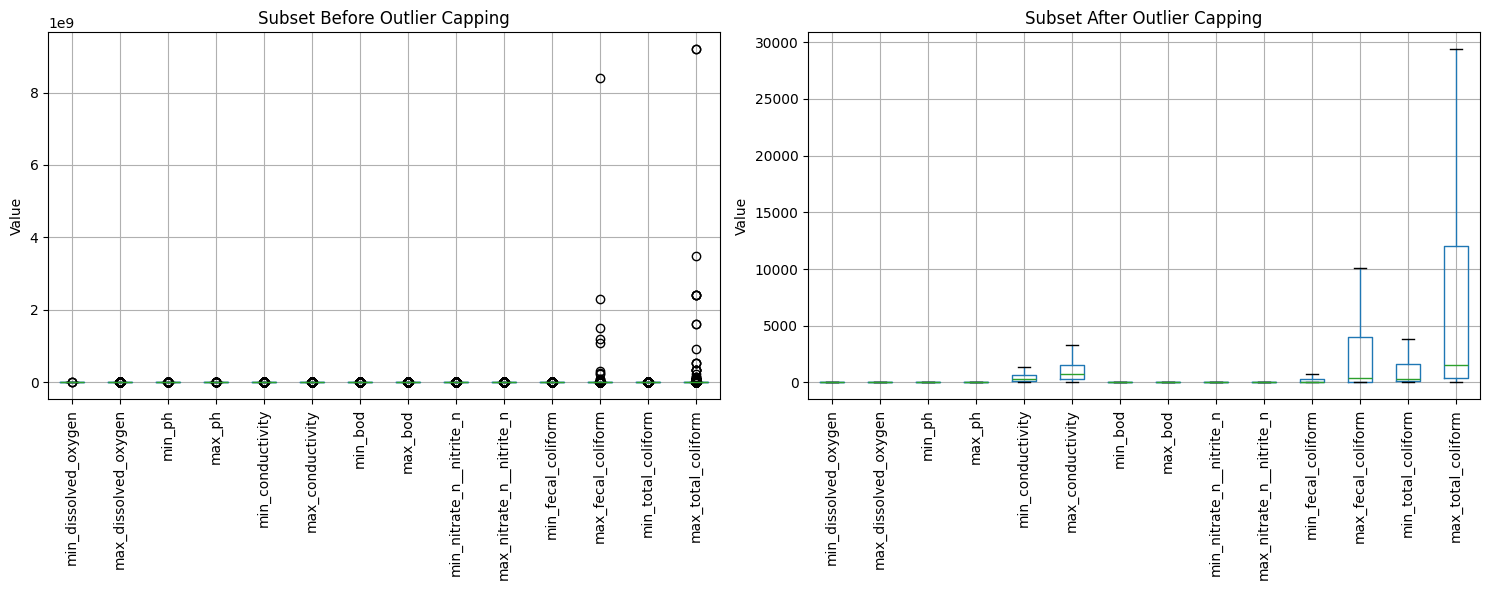


Outlier handling complete.


In [5]:
#################################################
# STEP 4: Handle Outliers Using IQR Capping
# This step detects and caps extreme values using interquartile range
#################################################

if 'df_subset' in locals() and not df_subset.empty:
    # --- Outlier Handling using IQR Capping (on Subset) ---
    df_capped = df_subset.copy()
    numeric_cols_for_outliers = [col for col in target_columns_minmax if col in df_capped.columns]

    print("\nApplying IQR capping for outlier handling...")
    for col in numeric_cols_for_outliers:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1

        if IQR > 0: # Avoid division by zero or issues with constant columns
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_low = (df_capped[col] < lower_bound).sum()
            outliers_high = (df_capped[col] > upper_bound).sum()

            if outliers_low > 0 or outliers_high > 0:
                df_capped[col] = np.clip(df_capped[col], lower_bound, upper_bound)
                print(f"  - Capped {outliers_low} low / {outliers_high} high outliers in '{col}'. Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Visualize Boxplots Before and After (on the subset columns)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    df_subset[numeric_cols_for_outliers].boxplot(rot=90)
    plt.title('Subset Before Outlier Capping')
    plt.ylabel('Value')

    plt.subplot(1, 2, 2)
    df_capped[numeric_cols_for_outliers].boxplot(rot=90)
    plt.title('Subset After Outlier Capping')
    plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
    df_processed = df_capped.copy() # Proceed with the capped data
    print("\nOutlier handling complete.")
else:
     print("Skipping step - DataFrame 'df_subset' not available for outlier handling.")

In [6]:
#################################################
# STEP 5: Feature Engineering (AVERAGE Values Only)
# This step calculates the AVERAGE value for each min/max pair of water quality parameters
# and removes the original min/max columns + stn_code
#################################################

if 'df_processed' in locals() and not df_processed.empty:
    # --- Feature Engineering: Calculate Average ONLY ---
    df_eng = df_processed.copy() # Start with the capped data
    engineered_features = []
    identifier_col = 'stn_code' # Define identifier name
    
    print("\nEngineering Average features ONLY...")
    
    # Define pairs of min/max columns for each parameter
    param_map = {
        'do': ('min_dissolved_oxygen', 'max_dissolved_oxygen'),
        'ph': ('min_ph', 'max_ph'),
        'cond': ('min_conductivity', 'max_conductivity'),
        'bod': ('min_bod', 'max_bod'),
        'nit': ('min_nitrate_n__nitrite_n', 'max_nitrate_n__nitrite_n'),
        'fcol': ('min_fecal_coliform', 'max_fecal_coliform'),
        'tcol': ('min_total_coliform', 'max_total_coliform')
    }

    cols_to_drop_after_eng = []
    
    # For each parameter, create an average feature
    for prefix, (min_col, max_col) in param_map.items():
        if min_col in df_eng.columns and max_col in df_eng.columns:
            avg_col = f'avg_{prefix}'
            
            # Calculate Average ONLY (not range)
            df_eng[avg_col] = (df_eng[min_col] + df_eng[max_col]) / 2
            
            engineered_features.append(avg_col) # Add only avg feature
            cols_to_drop_after_eng.extend([min_col, max_col])
            print(f"  - Created '{avg_col}'")
        else:
            print(f"  - Skipping {prefix}: Columns '{min_col}' or '{max_col}' not found.")

    # Drop original Min/Max columns
    existing_cols_to_drop = [col for col in cols_to_drop_after_eng if col in df_eng.columns]
    if existing_cols_to_drop:
         df_eng.drop(columns=existing_cols_to_drop, inplace=True)
         print(f"\nDropped original Min/Max columns: {existing_cols_to_drop}")
         
    # IMPORTANT: Explicitly Drop stn_code if it exists
    if identifier_col in df_eng.columns:
        print(f"\nExplicitly dropping identifier column: '{identifier_col}'")
        df_eng.drop(columns=[identifier_col], inplace=True)
        
    # Keep only the successfully engineered 'average' features
    final_feature_cols = [col for col in engineered_features if col in df_eng.columns]
    df_final_features = df_eng[final_feature_cols].copy()
         
    print("\nFeature engineering (Average Only) complete.")
    print("Shape after engineering:", df_final_features.shape)
    print("Final features:", df_final_features.columns.tolist())
    print(df_final_features.head())
else:
     print("Skipping step - DataFrame 'df_processed' not available for feature engineering.")


Engineering Average features ONLY...
  - Created 'avg_do'
  - Created 'avg_ph'
  - Created 'avg_cond'
  - Created 'avg_bod'
  - Created 'avg_nit'
  - Created 'avg_fcol'
  - Created 'avg_tcol'

Dropped original Min/Max columns: ['min_dissolved_oxygen', 'max_dissolved_oxygen', 'min_ph', 'max_ph', 'min_conductivity', 'max_conductivity', 'min_bod', 'max_bod', 'min_nitrate_n__nitrite_n', 'max_nitrate_n__nitrite_n', 'min_fecal_coliform', 'max_fecal_coliform', 'min_total_coliform', 'max_total_coliform']

Explicitly dropping identifier column: 'stn_code'

Feature engineering (Average Only) complete.
Shape after engineering: (2755, 7)
Final features: ['avg_do', 'avg_ph', 'avg_cond', 'avg_bod', 'avg_nit', 'avg_fcol', 'avg_tcol']
   avg_do  avg_ph  avg_cond  avg_bod  avg_nit  avg_fcol  avg_tcol
0    5.20    7.50   872.000     2.60    3.115     369.5    1274.5
1    5.95    7.90  1007.500     3.85    1.740      14.0     335.0
2    4.90    7.80   645.000     3.60    1.770      23.0     195.0
3    5

In [7]:
#################################################
# STEP 6: Robust Scaling of Engineered Features
# This step scales data using RobustScaler (median/IQR) which is less sensitive to outliers
#################################################

from sklearn.preprocessing import RobustScaler # Using RobustScaler instead of StandardScaler
import pandas as pd # Ensure pandas is imported

# df_final_features should now contain only the 7 'average' engineered features
if 'df_final_features' in locals() and isinstance(df_final_features, pd.DataFrame) and not df_final_features.empty:
    
    # --- Scale the Average Engineered Features using RobustScaler ---
    features_to_scale = df_final_features.columns.tolist() # Select all columns in df_final_features
    
    if not features_to_scale:
        print("Error: No average features found to scale.")
        X_scaled_robust = None
    else:
        print(f"\nScaling {len(features_to_scale)} average features using RobustScaler: {features_to_scale}")
        scaler = RobustScaler() # RobustScaler uses median and IQR, making it less sensitive to outliers
        
        # Keep index for potential future use
        original_index = df_final_features.index 
        
        # Apply scaling
        X_scaled_robust = scaler.fit_transform(df_final_features)
        print("Robust Scaling complete. Shape:", X_scaled_robust.shape)
        
        # Optional: Convert back to DataFrame for inspection
        # df_scaled_robust = pd.DataFrame(X_scaled_robust, columns=features_to_scale, index=original_index)
        # print(df_scaled_robust.head())
else:
     print("Skipping step - DataFrame 'df_final_features' not available or empty.")
     X_scaled_robust = None


Scaling 7 average features using RobustScaler: ['avg_do', 'avg_ph', 'avg_cond', 'avg_bod', 'avg_nit', 'avg_fcol', 'avg_tcol']
Robust Scaling complete. Shape: (2755, 7)



Applying PCA to 7 scaled features...
Number of components to explain >= 95% variance: 5


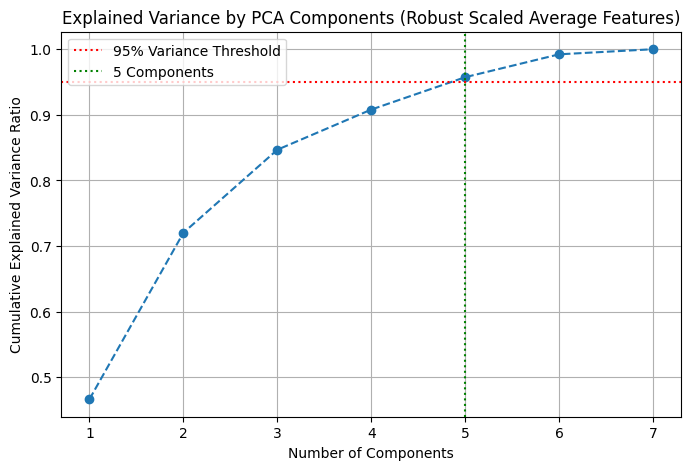


Variance explained by first 2 components: 0.7201


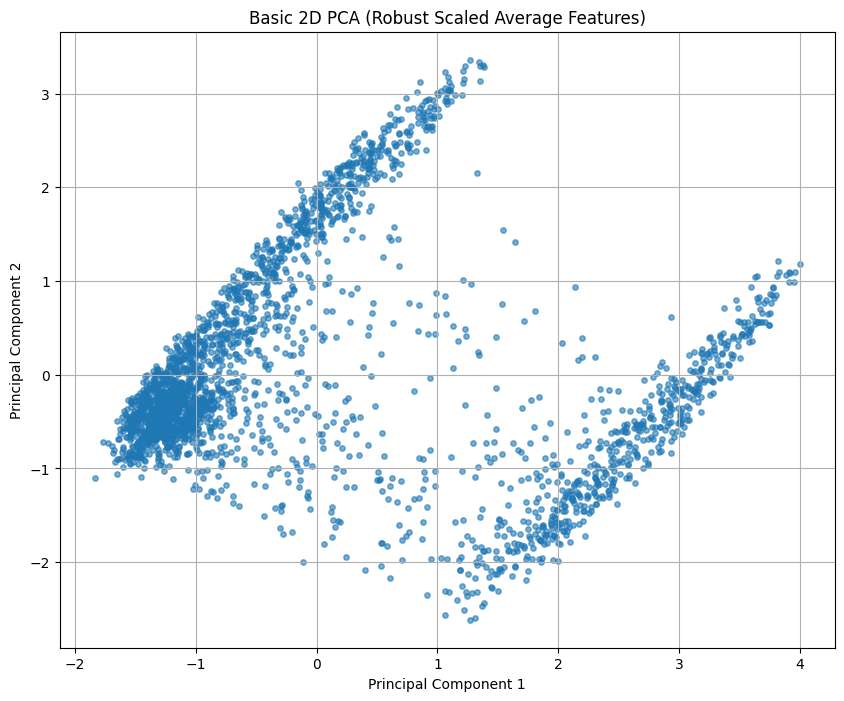


Basic PCA visualization complete.


In [8]:
#################################################
# STEP 7: Basic PCA Analysis and Visualization
# This step applies standard PCA to see how many components explain most variance
#################################################

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Use X_scaled_robust from Cell 6
if 'X_scaled_robust' in locals() and X_scaled_robust is not None:
    print(f"\nApplying PCA to {X_scaled_robust.shape[1]} scaled features...")
    
    # --- PCA for Explained Variance ---
    pca_full = PCA()
    pca_full.fit(X_scaled_robust)
    
    # Calculate cumulative explained variance
    cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    print(f"Number of components to explain >= 95% variance: {n_components_95}")

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance by PCA Components (Robust Scaled Average Features)')
    plt.axhline(y=0.95, color='r', linestyle=':', label='95% Variance Threshold')
    plt.axvline(x=n_components_95, color='g', linestyle=':', label=f'{n_components_95} Components')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Basic 2D PCA Visualization ---
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_scaled_robust)
    
    print(f"\nVariance explained by first 2 components: {pca_2d.explained_variance_ratio_.sum():.4f}")

    # Create DataFrame for plotting
    if 'original_index' in locals():
        df_pca_2d = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'], index=original_index)
    else:
        df_pca_2d = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])

    # Plot basic 2D PCA
    plt.figure(figsize=(10, 8))
    plt.scatter(df_pca_2d['PC1'], df_pca_2d['PC2'], alpha=0.6, s=15)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Basic 2D PCA (Robust Scaled Average Features)')
    plt.grid(True)
    plt.show()
    
    print("\nBasic PCA visualization complete.")
    
else:
    print("Skipping PCA step - Robust scaled data ('X_scaled_robust') not available.")

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/0l/mrtqnjts01v_48lkl9674g3r0000gn/T/ipykernel_25961/1663198880.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 'X_scaled_robust' is None or not isinstance(X_scaled_robust, np.ndarray):



Comparing various 2D dimensionality reduction techniques with extreme outlier removal...
  Original data shape: (2755, 7)
  After outlier removal: (1613, 7) (41.5% removed)
  (IPCA batch size: 100)
  (UMAP using n_neighbors=5, min_dist=0.0)
  Fitting Standard PCA...
    Completed in 0.00 seconds.
  Fitting Kernel PCA (RBF)...
    Completed in 0.12 seconds.
  Fitting Incremental PCA...
    Completed in 0.00 seconds.
  Fitting Sparse PCA...
    Completed in 0.39 seconds.
  Fitting Truncated SVD...
    Completed in 0.00 seconds.
  Fitting UMAP (n=5, md=0.0)...


/opt/homebrew/Caskroom/miniconda/base/envs/ml-asg/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml-asg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    Completed in 1.19 seconds.


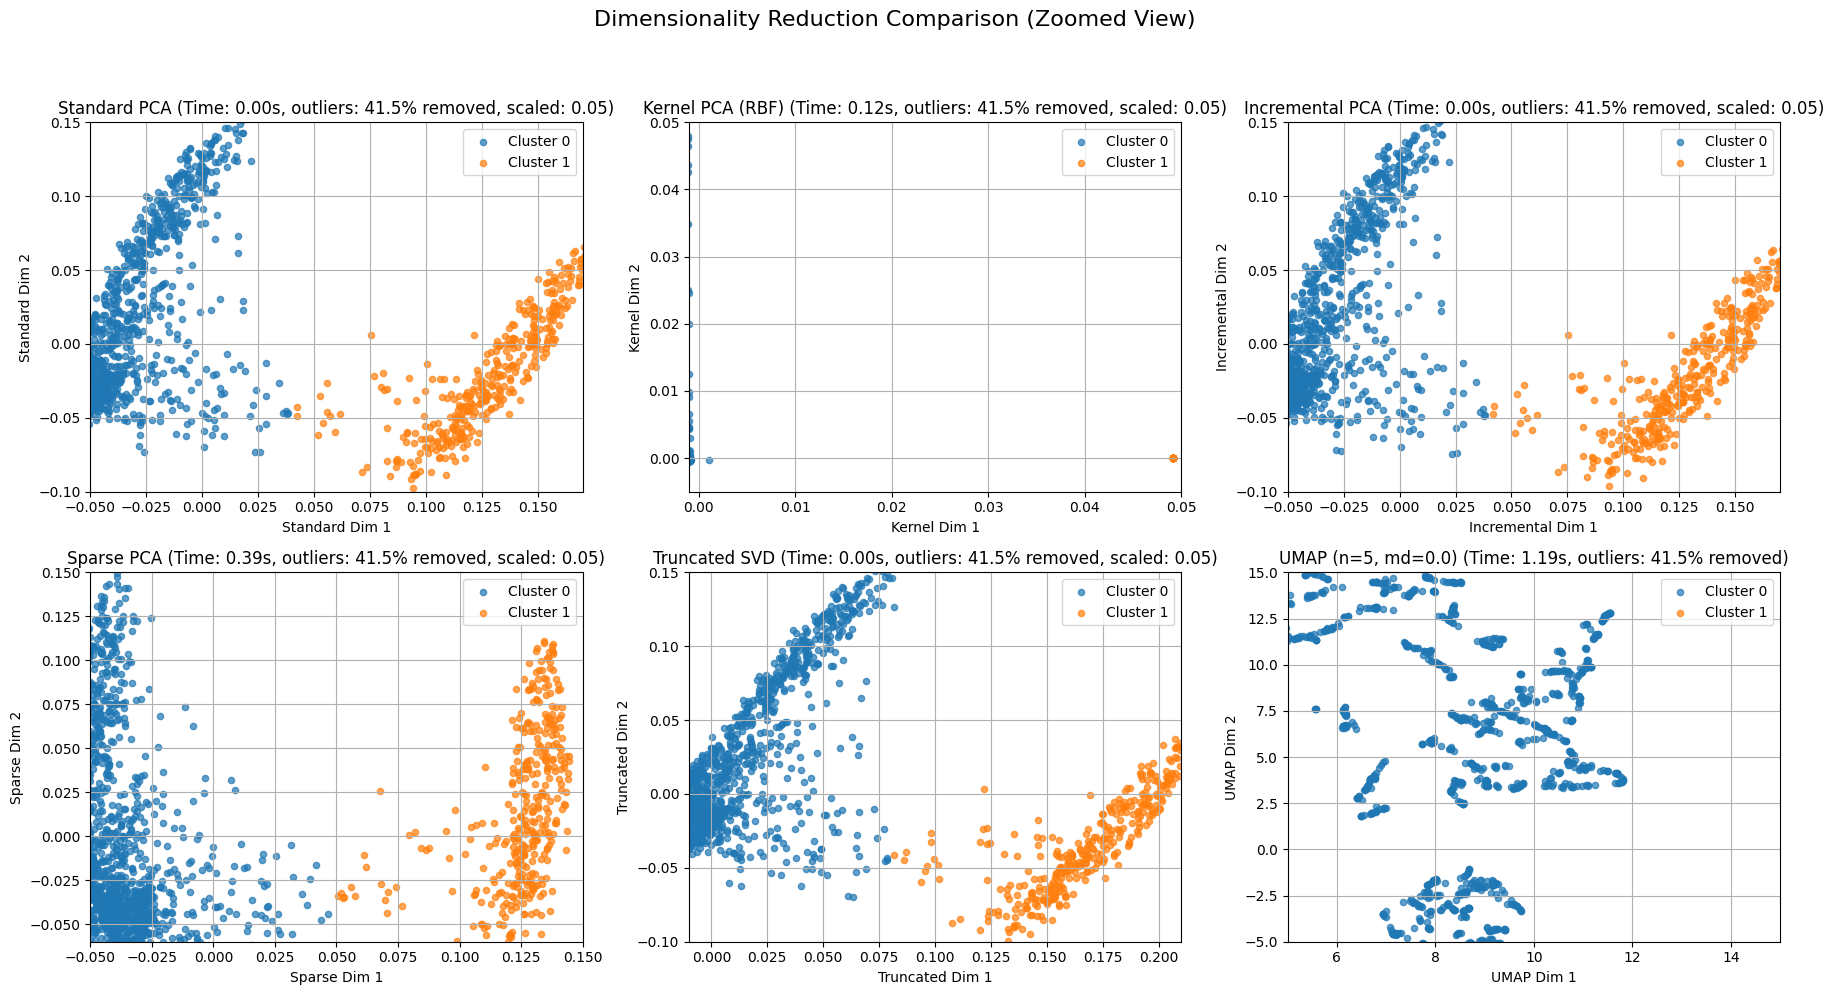

In [12]:
#################################################
# STEP 8: Compare Multiple Dimensionality Reduction Techniques
# This step applies aggressive outlier removal and scaling to pack points tightly
#################################################

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import IsolationForest
import umap # Ensure umap-learn is installed

# Use X_scaled_robust from Cell 6
if 'X_scaled_robust' is None or not isinstance(X_scaled_robust, np.ndarray):
    print("Error: Robust scaled data ('X_scaled_robust') is not available. Please run Cell 6 first.")
else:
    print(f"\nComparing various 2D dimensionality reduction techniques with extreme outlier removal...")
    
    # --- Apply two-stage outlier removal ---
    # Stage 1: Remove extreme outliers with isolation forest
    isolation_forest = IsolationForest(contamination=0.15, random_state=42)  # Remove 15% as outliers
    outlier_mask = isolation_forest.fit_predict(X_scaled_robust) == 1  # 1 = inlier, -1 = outlier
    
    # Stage 2: Remove outliers based on feature quantiles
    quantile_lower = 0.05  # 5th percentile
    quantile_upper = 0.95  # 95th percentile
    
    feature_mask = np.ones(X_scaled_robust.shape[0], dtype=bool)
    for col in range(X_scaled_robust.shape[1]):
        q_low, q_high = np.quantile(X_scaled_robust[:, col], [quantile_lower, quantile_upper])
        feature_mask &= (X_scaled_robust[:, col] >= q_low) & (X_scaled_robust[:, col] <= q_high)
    
    # Combine both methods for aggressive outlier removal
    final_mask = outlier_mask & feature_mask
    
    # Apply the mask to get clean data
    X_no_outliers = X_scaled_robust[final_mask]
    
    print(f"  Original data shape: {X_scaled_robust.shape}")
    print(f"  After outlier removal: {X_no_outliers.shape} ({(1 - len(X_no_outliers)/len(X_scaled_robust))*100:.1f}% removed)")
    
    # --- Prepare Models ---
    n_components = 2
    random_state = 42
    
    models = {}
    results = {}
    times = {}
    
    # Very aggressive scaling factor for bringing points closer together
    scaling_factor = 0.05  # Extremely small to pack points very tightly

    # Standard PCA
    models['Standard PCA'] = PCA(n_components=n_components, random_state=random_state)
    
    # Kernel PCA (RBF) with very high gamma to make points closer
    models['Kernel PCA (RBF)'] = KernelPCA(n_components=n_components, kernel='rbf', gamma=100, random_state=random_state)
    
    # Incremental PCA
    n_samples, n_features = X_no_outliers.shape
    batch_size = min(max(n_components, 100), n_samples) 
    if batch_size >= n_components:
         models['Incremental PCA'] = IncrementalPCA(n_components=n_components, batch_size=batch_size)
         print(f"  (IPCA batch size: {batch_size})")
    else:
        print(f"  (Skipping IPCA: batch_size ({batch_size}) < n_components ({n_components}))")
        
    # Sparse PCA
    models['Sparse PCA'] = SparsePCA(n_components=n_components, alpha=1.0, random_state=random_state, n_jobs=-1)
    
    # Truncated SVD
    if n_components < n_features:
        models['Truncated SVD'] = TruncatedSVD(n_components=n_components, random_state=random_state)
    else:
        print(f"  (Skipping SVD: n_components ({n_components}) must be < n_features ({n_features}))")

    # --- UMAP with AGGRESSIVELY tuned parameters ---
    umap_neighbors = 5 
    umap_min_dist = 0.0 
    print(f"  (UMAP using n_neighbors={umap_neighbors}, min_dist={umap_min_dist})")
    models[f'UMAP (n={umap_neighbors}, md={umap_min_dist})'] = umap.UMAP(
        n_neighbors=umap_neighbors, 
        min_dist=umap_min_dist, 
        n_components=n_components, 
        metric='euclidean', 
        random_state=random_state
    )

    # --- Fit and Transform ---
    valid_model_names = list(models.keys()) 
    for name in valid_model_names:
        model = models[name]
        print(f"  Fitting {name}...")
        start_time = time.time()
        try:
            if name == 'Incremental PCA':
                 model.fit(X_no_outliers) 
                 X_reduced = model.transform(X_no_outliers)
            else:
                X_reduced = model.fit_transform(X_no_outliers)
            
            # Apply scaling to bring points closer together for all methods except UMAP
            if name != f'UMAP (n={umap_neighbors}, md={umap_min_dist})':
                X_reduced = X_reduced * scaling_factor
                
            results[name] = X_reduced
            times[name] = time.time() - start_time
            print(f"    Completed in {times[name]:.2f} seconds.")
        except Exception as e:
            print(f"    ERROR fitting {name}: {e}")
            results[name] = None 

    # --- Plotting with zoomed axes ---
    successful_results = {k: v for k, v in results.items() if v is not None}
    num_plots = len(successful_results)
    
    if num_plots > 0:
        # Determine grid layout
        ncols = 3 if num_plots > 4 else 2
        nrows = (num_plots + ncols - 1) // ncols 
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5), squeeze=False) 
        axes = axes.flatten() 
        
        # Define custom zoom ranges for each method
        zoom_ranges = {
            'Standard PCA': {'x': (-0.05, 0.17), 'y': (-0.1, 0.15)},
            'Kernel PCA (RBF)': {'x': (-0.001, 0.05), 'y': (-0.005, 0.05)},
            'Incremental PCA': {'x': (-0.05, 0.17), 'y': (-0.1, 0.15)},
            'Sparse PCA': {'x': (-0.05, 0.15), 'y': (-0.06, 0.15)},
            'Truncated SVD': {'x': (-0.01, 0.21), 'y': (-0.1, 0.15)},
            f'UMAP (n={umap_neighbors}, md={umap_min_dist})': {'x': (5, 15), 'y': (-5, 15)},
        }
        
        # Function to identify clusters in each plot
        def get_clusters(X, n_clusters=2):
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(X)
            return labels
        
        plot_idx = 0
        for name, X_reduced in successful_results.items():
            ax = axes[plot_idx]
            
            # Color points by cluster
            cluster_labels = get_clusters(X_reduced)
            for cluster_id in range(2):  # Assuming 2 clusters
                mask = cluster_labels == cluster_id
                ax.scatter(
                    X_reduced[mask, 0], 
                    X_reduced[mask, 1], 
                    alpha=0.7, 
                    s=20,
                    label=f'Cluster {cluster_id}'
                )
            
            # Add outlier removal and scaling info to title
            outlier_info = f"outliers: {(1 - len(X_no_outliers)/len(X_scaled_robust))*100:.1f}% removed"
            if name != f'UMAP (n={umap_neighbors}, md={umap_min_dist})':
                ax.set_title(f'{name} (Time: {times[name]:.2f}s, {outlier_info}, scaled: {scaling_factor})')
            else:
                ax.set_title(f'{name} (Time: {times[name]:.2f}s, {outlier_info})')
            
            # Set custom axis limits for zooming
            if name in zoom_ranges:
                ax.set_xlim(zoom_ranges[name]['x'])
                ax.set_ylim(zoom_ranges[name]['y'])
            
            ax.set_xlabel(f'{name.split(" ")[0]} Dim 1') # Shorten label
            ax.set_ylabel(f'{name.split(" ")[0]} Dim 2') # Shorten label
            ax.grid(True)
            ax.legend(loc='best')
            plot_idx += 1
            
        # Hide any unused subplots
        for i in range(plot_idx, len(axes)):
            fig.delaxes(axes[i])
            
        fig.suptitle('Dimensionality Reduction Comparison (Zoomed View)', fontsize=16, y=1.02)
        fig.tight_layout(rect=[0, 0.03, 1, 0.98]) 
        plt.show()
    else:
        print("No dimensionality reduction results available to plot.")